In [1]:
import csv
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def get_data(filename):
    with open(filename) as training_file:
        
        lines = training_file.readlines()[1:]
        random.shuffle(lines)
        
        labelslist = []
        imageslist = []
        
        for line in lines:
            
            row = line.split(",")
            
            labelslist.append(row[0])
            
            image = np.array(row[1:]).astype(np.float32)
            imageslist.append( np.array_split(image, 28) )
        
        split_point = int(len(lines) * 0.9)
        
        train_labelslist = labelslist[:split_point]
        val_labelslist = labelslist[split_point:]
        
        train_imageslist = imageslist[:split_point]
        val_imageslist = imageslist[split_point:]
        
        train_labels = np.array(train_labelslist).astype(np.float32)
        val_labels = np.array(val_labelslist).astype(np.float32)
        
        train_images = np.array(train_imageslist, dtype=object)
        val_images = np.array(val_imageslist, dtype=object)
        
    return train_labels, train_images, val_labels, val_images

training_labels, training_images, validation_labels, validation_images = get_data('../input/digit-recognizer/train.csv')

training_images = np.expand_dims(training_images, axis=3)
validation_images = np.expand_dims(validation_images, axis=3)

print(training_labels.shape)
print(training_images.shape)
print(validation_labels.shape)
print(validation_images.shape)

(37800,)
(37800, 28, 28, 1)
(4200,)
(4200, 28, 28, 1)


In [3]:
train_datagen = ImageDataGenerator(
                          rescale = 1./255,
                          rotation_range=60,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          shear_range=0.2,
                          zoom_range=0.2,
                          fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(training_images,
                                    training_labels,
                                    batch_size=200)

validation_generator = validation_datagen.flow(validation_images,
                                            validation_labels,
                                            batch_size=200)

In [4]:
class myCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") >= 0.992:
            print("Reached 99.2% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCb()

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, steps_per_epoch=189, validation_data = validation_generator, verbose = 1, validation_steps=21, callbacks=[callbacks])

2021-11-12 17:24:50.032621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:24:50.184191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:24:50.185504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:24:50.189216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/50


2021-11-12 17:24:54.506671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


189/189 [==============================] - 22s 81ms/step - loss: 0.8634 - accuracy: 0.7167 - val_loss: 0.1871 - val_accuracy: 0.9445
Epoch 2/50
189/189 [==============================] - 16s 83ms/step - loss: 0.3388 - accuracy: 0.8954 - val_loss: 0.1170 - val_accuracy: 0.9629
Epoch 3/50
189/189 [==============================] - 15s 81ms/step - loss: 0.2456 - accuracy: 0.9254 - val_loss: 0.0975 - val_accuracy: 0.9707
Epoch 4/50
189/189 [==============================] - 16s 84ms/step - loss: 0.1994 - accuracy: 0.9383 - val_loss: 0.0937 - val_accuracy: 0.9719
Epoch 5/50
189/189 [==============================] - 15s 79ms/step - loss: 0.1761 - accuracy: 0.9453 - val_loss: 0.0567 - val_accuracy: 0.9836
Epoch 6/50
189/189 [==============================] - 16s 87ms/step - loss: 0.1549 - accuracy: 0.9514 - val_loss: 0.0812 - val_accuracy: 0.9733
Epoch 7/50
189/189 [==============================] - 15s 82ms/step - loss: 0.1383 - accuracy: 0.9571 - val_loss: 0.0518 - val_accuracy: 0.9831
Epo

In [6]:
model.evaluate(validation_generator, verbose=1)

21/21 [==============================] - 0s 10ms/step - loss: 0.0245 - accuracy: 0.9933


[0.02450508438050747, 0.9933333396911621]

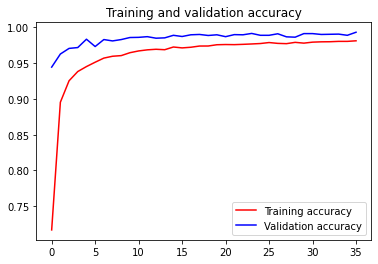

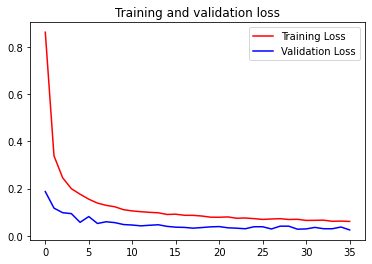

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
def prep_test_data(filename):
    with open(filename) as training_file:
        
        lines = training_file.readlines()[1:]
        
        imageslist = []
        
        for line in lines:
            row = line.split(",")
            image = np.array(row).astype(np.float32)
            imageslist.append( np.array_split(image, 28) )
        
        test_images = np.array(imageslist, dtype=object)
        
    return test_images

test_images = prep_test_data('../input/digit-recognizer/test.csv')

test_images = np.expand_dims(test_images, axis=3)

print(test_images.shape)

(28000, 28, 28, 1)


In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow(test_images, shuffle=False)

test_preds = model.predict(test_generator)

test_preds_classes = np.argmax(test_preds,axis = 1) 

In [10]:
submission = pd.DataFrame({'ImageId': range(1,28001), 'Label': test_preds_classes})
submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [11]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
